## Fraud Detection
Fraud detection identifies unauthorized or suspicious credit card transactions to prevent financial losses and protect users. It’s critical in credit card systems due to rising cybercrime, ensuring trust and security. Below is a hands-on analysis of a credit card transaction dataset to explore fraud detection techniques.

The original dataset can be accessed [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data). For an in-depth overview, please refer to the introduction article available [here](https://www.nicoletangsy.com/article/revisiting-machine-learning-fraud-detection).

---
#### Environment Set-up

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

---
#### Data Understanding

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
# hows the data looks like
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Most features are PCA-transformed, simplifying data preprocessing but requiring careful model selection.

In [4]:
# data size
print("DF Size:",df.shape)

for col_name, col_type in df.dtypes.items():

    # data type
    print(f"Column: {col_name} ({col_type})")

    # # data unique values
    # print(f"Unique Values: {df[col_name].nunique()}") 
    # print(f"Values Example: {df[col_name].unique()[:3]}") 

    # data min max
    print(f"Min. Values: {df[col_name].min()}") 
    print(f"Max. Values: {df[col_name].max()}") 

    # missing data
    print(f"NA Values: {df[df[col_name].isna()].shape[0]}")
    print('\n')

# V1 - 30 is after processing, so we need to consider perform similar processing for amount

DF Size: (284807, 31)
Column: Time (float64)
Min. Values: 0.0
Max. Values: 172792.0
NA Values: 0


Column: V1 (float64)
Min. Values: -56.407509631329
Max. Values: 2.45492999121121
NA Values: 0


Column: V2 (float64)
Min. Values: -72.7157275629303
Max. Values: 22.0577289904909
NA Values: 0


Column: V3 (float64)
Min. Values: -48.3255893623954
Max. Values: 9.38255843282114
NA Values: 0


Column: V4 (float64)
Min. Values: -5.68317119816995
Max. Values: 16.8753440335975
NA Values: 0


Column: V5 (float64)
Min. Values: -113.743306711146
Max. Values: 34.8016658766686
NA Values: 0


Column: V6 (float64)
Min. Values: -26.1605059358433
Max. Values: 73.3016255459646
NA Values: 0


Column: V7 (float64)
Min. Values: -43.5572415712451
Max. Values: 120.589493945238
NA Values: 0


Column: V8 (float64)
Min. Values: -73.2167184552674
Max. Values: 20.0072083651213
NA Values: 0


Column: V9 (float64)
Min. Values: -13.4340663182301
Max. Values: 15.5949946071278
NA Values: 0


Column: V10 (float64)
Min. Va

In [5]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
492/(492+284315)

0.001727485630620034

The dataset is imbalanced, with only 1.7% of data points in the minority class, necessitating rebalancing for robust model training and cautious evaluation metric selection to avoid masking weaknesses in minority class prediction.

---
#### Data Understanding & EDA 

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

<Axes: xlabel='Time'>

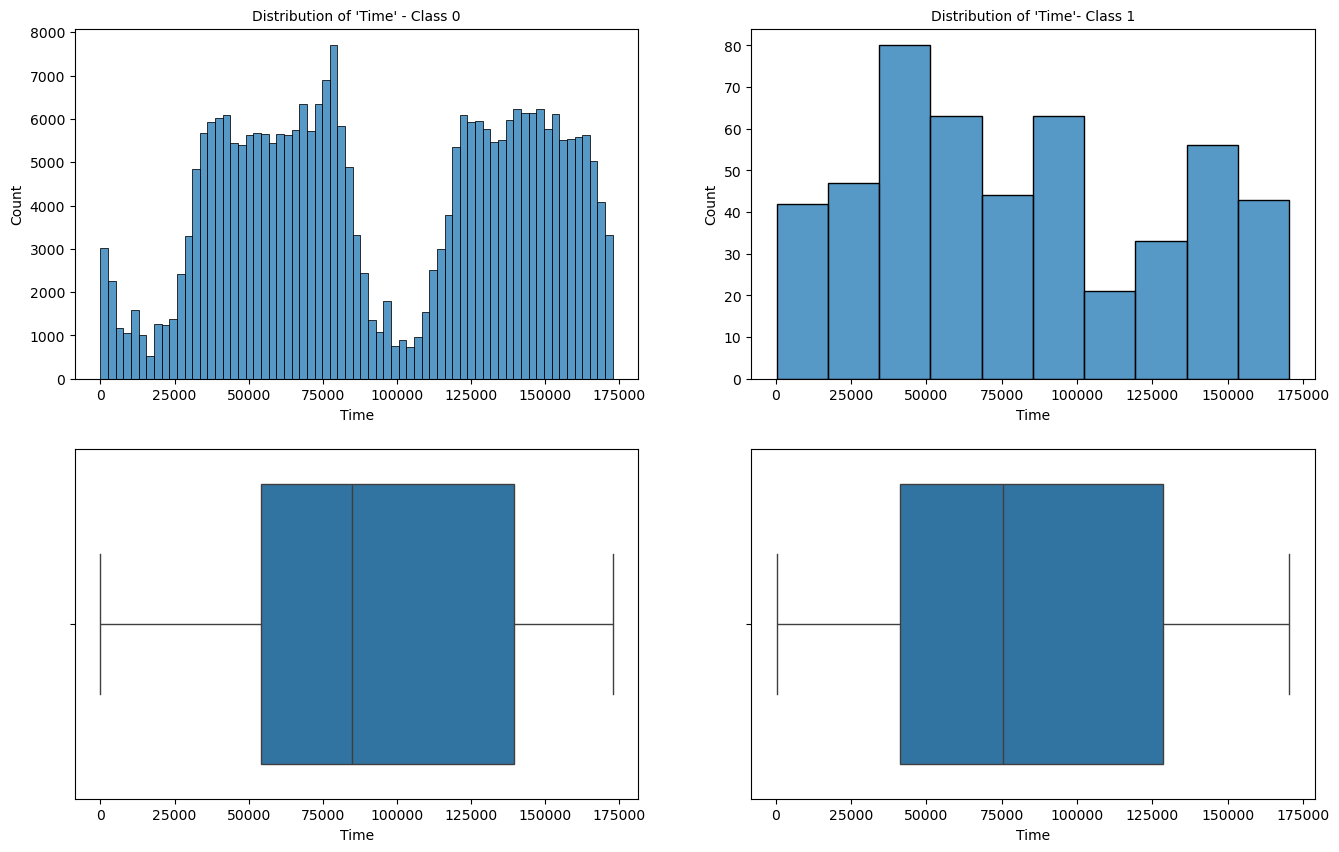

In [8]:
# Customer Data
f, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(x='Time', data=df[df['Class']==0], ax=axes[0,0]).set_title("Distribution of 'Time' - Class 0", fontsize=10)
sns.histplot(x='Time', data=df[df['Class']==1], ax=axes[0,1]).set_title("Distribution of 'Time'- Class 1", fontsize=10)
sns.boxplot(x='Time', data=df[df['Class']==0], ax=axes[1,0])
sns.boxplot(x='Time', data=df[df['Class']==1], ax=axes[1,1])

# 2 different distribution

No majority difference observed from the distribution graph, while we can further examinate later.

<Axes: xlabel='Amount'>

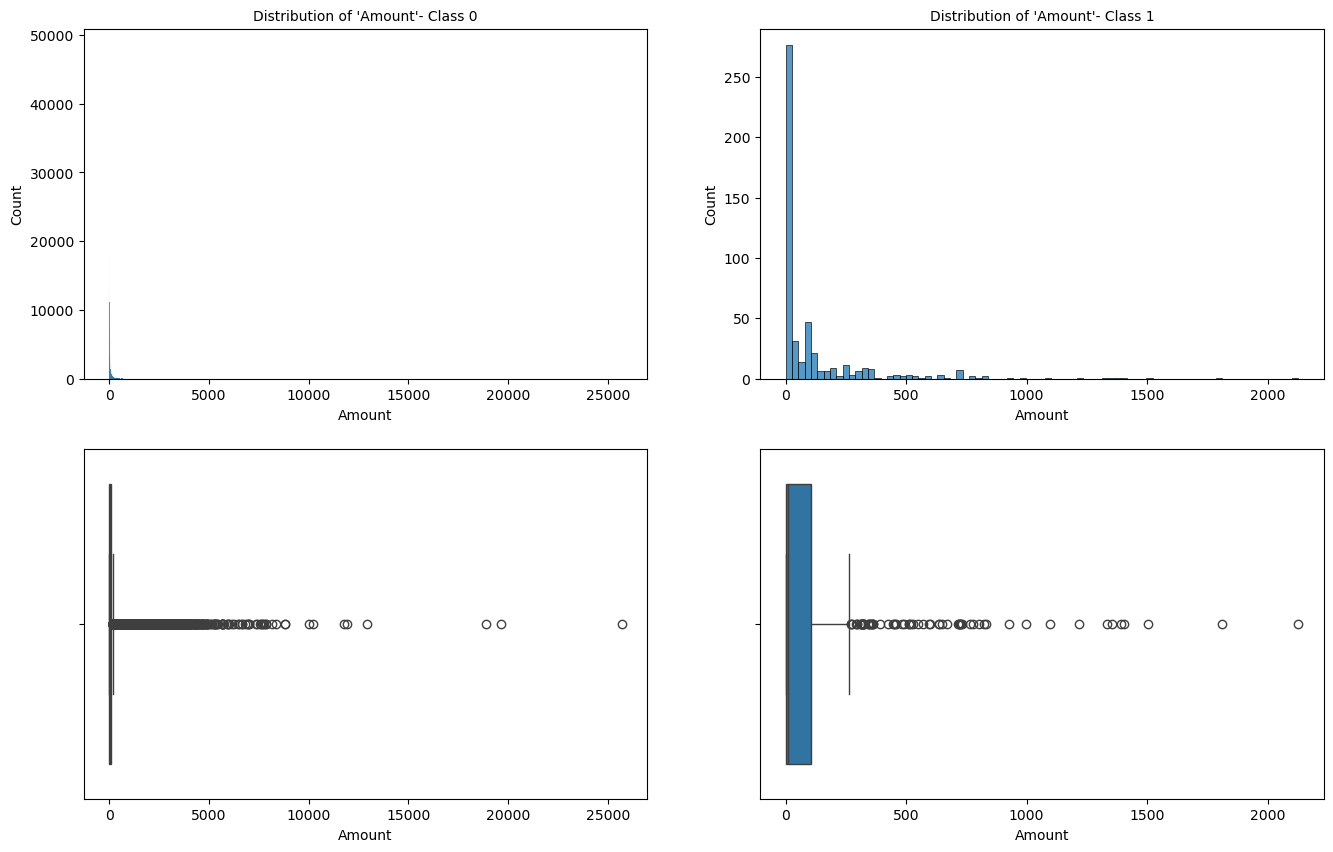

In [9]:
# Customer Data
f, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(x='Amount', data=df[df['Class']==0], ax=axes[0,0]).set_title("Distribution of 'Amount'- Class 0", fontsize=10)
sns.histplot(x='Amount', data=df[df['Class']==1], ax=axes[0,1]).set_title("Distribution of 'Amount'- Class 1", fontsize=10)
sns.boxplot(x='Amount', data=df[df['Class']==0], ax=axes[1,0])
sns.boxplot(x='Amount', data=df[df['Class']==1], ax=axes[1,1])

# skewed distribution, standardize

Normal transaction data points range from 0 to 25,000, significantly larger in scale than fraud transactions.

---
#### Feature Engineering & Correlation

In [10]:
df.corr()['Class'].sort_values()
# get some feelings

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

---
### Functions for evaluation

In [ ]:
def evaluation_summary(test, pred):
    accuracy = accuracy_score(test, pred) #this will be misleaded by unbalance dataset
    print("Accuracy Score:", accuracy)

    auc_score = roc_auc_score(test, pred) #this will be misleaded by unbalance dataset
    print("AUC Score:", auc_score)

    f1 = f1_score(test, pred)
    print("f1 Score:", f1)

    ap_score  = average_precision_score(test, pred)
    print("AP Score:", ap_score)

---
#### Baseline Model - Training
(Without Resampling) 

In [11]:
# Split the data into features (X) and target (y)
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# train the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# predict
y_pred = rf.predict(X_test)

In [15]:
evaluation_summary(y_test, y_pred)

Accuracy Score: 0.9995259997893332
AUC Score: 0.872431393773041
f1 Score: 0.8439306358381503
AP Score: 0.725472902689393


Imbalanced data can mislead accuracy and AUC scores, obscuring model performance.

---
#### Features Importances
Understanding each feature’s contribution to decision tree creation.

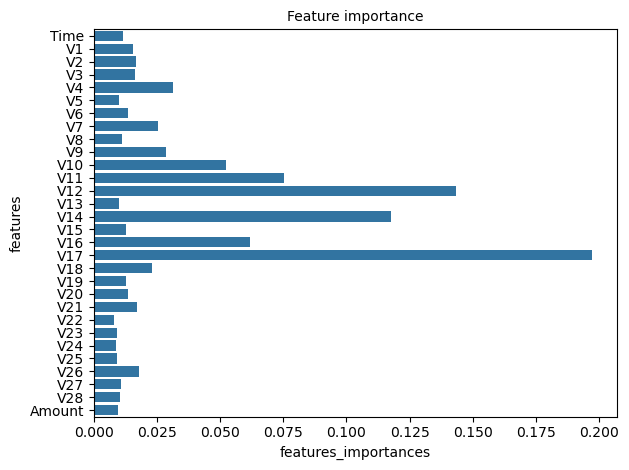

In [16]:
importances = rf.feature_importances_
feature_names = X_train.columns

forest_importances = pd.DataFrame(importances, index=feature_names).reset_index()
forest_importances.columns = ['features', 'features_importances']

fig, ax = plt.subplots()
sns.barplot(data=forest_importances, x='features_importances', y='features')
ax.set_title("Feature importance", fontsize=10)
fig.tight_layout()


V17, V12, V14, the top 3 contributors. 

---
#### Revised Model - Resampling

SMOTETomek combines SMOTE for oversampling the minority class with synthetic data and Tomek Links for removing noisy, closely paired samples, balancing the dataset and improving classifier performance. Relying solely on SMOTE risks introducing noise alongside quality data due to the small minority class.

In [17]:
sm = SMOTETomek(random_state=42, tomek=TomekLinks(sampling_strategy='majority'))

X_res, y_res = sm.fit_resample(X_train, y_train)
y_train.value_counts(), y_res.value_counts()

(Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 1    227451
 0    226769
 Name: count, dtype: int64)

In [18]:
# train the model
rf = RandomForestClassifier()
rf.fit(X_res, y_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# predict
y_res_pred = rf.predict(X_test)
evaluation_summary(y_test, y_res_pred)

Accuracy Score: 0.9995259997893332
AUC Score: 0.9131773770284703
f1 Score: 0.8571428571428571
AP Score: 0.7360015170148528


ccuracy Score: 0.9995259997893332
AUC Score: 0.872431393773041
f1 Score: 0.8439306358381503
AP Score: 0.725472902689393

Rebalancing reduces accuracy and AUC scores but slightly improves F1 and AP scores, indicating a need for further investigation to enhance model performance.